# Loading CIFAR-10

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10

In [18]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape  == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape  == (10000, 1)

y_train = np.squeeze(y_train)
y_test  = np.squeeze(y_test)

data_labels = {
    0 : 'airplane',
    1 : 'automobile',
    2 : 'bird',
    3 : 'cat',
    4 : 'deer',
    5 : 'dog',
    6 : 'frog',
    7 : 'horse',
    8 : 'ship',
    9 : 'truck'
}

## Plotting some samples

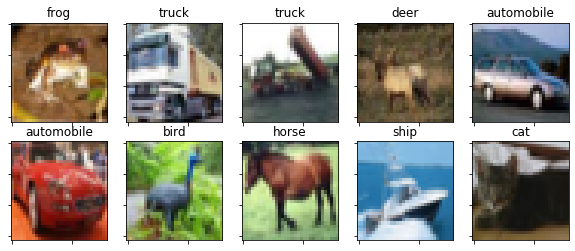

In [21]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,5, figsize=(10,4))

counter = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(x_train[counter], aspect='auto')
        ax[i,j].set_title(data_labels[y_train[counter]])
        ax[i,j].set_yticklabels([])
        ax[i,j].set_xticklabels([])
        counter += 1

## Counting labels

In [54]:
for i in data_labels.keys():
    print(f'{data_labels[i]} : {len(np.where(y_train==i)[0])}')

airplane : 4012
automobile : 3981
bird : 4010
cat : 3971
deer : 3990
dog : 3991
frog : 4019
horse : 4025
ship : 4020
truck : 3981


## Split validation

In [28]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, shuffle=True)

# MLP

## Data prepration

In [30]:
pixels = 32*32*3

x_tr = np.reshape(x_train, (-1, pixels))/255
x_va = np.reshape(x_valid, (-1, pixels))/255
x_te = np.reshape(x_test , (-1, pixels))/255

print(x_tr.shape, x_va.shape, x_te.shape)

(40000, 3072) (10000, 3072) (10000, 3072)


## MLP definition

In [61]:
from tensorflow.keras.layers import Dense, Dropout, Input, Softmax, Activation

def get_mlp(layers, dropout = 0.25, act = tf.nn.relu):
    model = keras.Sequential()
    model.add(Input(shape=(layers[0],)))
    
    depth = len(layers)-1
    for i in range(1, depth+1):
        model.add(Dense(units=layers[i], name=f'dense-{i}'))
        if i != depth:
            model.add(Activation(act, name=f'activation-{i}'))
            if dropout > 0:
                model.add(Dropout(rate=dropout))
        else:
            model.add(Softmax(axis=1, name='softmax'))
    return model

In [62]:
layers = [pixels, 1024, 256, 10]
model  = get_mlp(layers, dropout=0)

# building the model using a dummy input
dummy = tf.random.normal(x_tr[0:2,:].shape)
_ = model.predict(dummy) 

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense-1 (Dense)             (None, 1024)              3146752   
                                                                 
 activation-1 (Activation)   (None, 1024)              0         
                                                                 
 dense-2 (Dense)             (None, 256)               262400    
                                                                 
 activation-2 (Activation)   (None, 256)               0         
                                                                 
 dense-3 (Dense)             (None, 10)                2570      
                                                                 
 softmax (Softmax)           (None, 10)                0         
                                                                 
Total params: 3,411,722
Trainable params: 3,411,722
N

## MLP training

In [63]:
lr = 0.001

model.compile(
    optimizer = tf.optimizers.Adam(learning_rate=lr),
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [65]:
bs = 250
ep = 5

hist = model.fit(
    x_tr, y_train,
    batch_size = bs, epochs = ep,
    validation_data = (x_va,y_valid),
    verbose=2
)

Epoch 1/5
160/160 - 8s - loss: 2.0834 - accuracy: 0.2795 - val_loss: 1.8350 - val_accuracy: 0.3646 - 8s/epoch - 52ms/step
Epoch 2/5
160/160 - 7s - loss: 1.7817 - accuracy: 0.3691 - val_loss: 1.7386 - val_accuracy: 0.3830 - 7s/epoch - 44ms/step
Epoch 3/5
160/160 - 7s - loss: 1.6839 - accuracy: 0.4040 - val_loss: 1.6577 - val_accuracy: 0.4111 - 7s/epoch - 43ms/step
Epoch 4/5
160/160 - 7s - loss: 1.6287 - accuracy: 0.4225 - val_loss: 1.6225 - val_accuracy: 0.4210 - 7s/epoch - 44ms/step
Epoch 5/5
160/160 - 8s - loss: 1.5800 - accuracy: 0.4402 - val_loss: 1.5975 - val_accuracy: 0.4309 - 8s/epoch - 51ms/step
